In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
import os
from lesanalysis import *

## Read profile data

In [2]:
casename = 'Shear'
if casename == 'Langmuir':
    inputfile0_dir = '/Users/qingli/data/NCARLES/archive_les/hist/R8_BF05WD05WV12_ST01_ens01'
    inputfile1_dir = '/Users/qingli/data/palm/NCARLES-TEST01-WS'
elif casename == 'Shear':
    inputfile0_dir = '/Users/qingli/data/NCARLES/archive_les/hist/R8_BF05WD05WV00_ST01_ens01'
    inputfile1_dir = '/Users/qingli/data/palm/NCARLES-TEST00-WS'
elif casename == 'Langmuir-PW':
    inputfile0_dir = '/Users/qingli/data/NCARLES/archive_les/hist/R8_BF05WD05WV12_ST01_ens01'
    inputfile1_dir = '/Users/qingli/data/palm/NCARLES-TEST01-PW'
elif casename == 'Shear-PW':
    inputfile0_dir = '/Users/qingli/data/NCARLES/archive_les/hist/R8_BF05WD05WV00_ST01_ens01'
    inputfile1_dir = '/Users/qingli/data/palm/NCARLES-TEST00-PW'
else:
    raise ValueError('Case name \'{}\' not supported.'.format(casename))

inputfile0_pfl   = inputfile0_dir+'/his.mp.vis.000001.036001.nc'
inputfile1_pfl   = inputfile1_dir+'/DATA_1D_PR_NETCDF'
data0_pfl   = NCARLESData1DPR(inputfile0_pfl)
data1_pfl   = PALMData1DPR(inputfile1_pfl)

plot_figure = True
fig_root = '/Users/qingli/work/palm/Tests/cmp_ncarles/'+casename
os.makedirs(fig_root, exist_ok=True)

## Parameters

In [3]:
# Gravitational acceleration (m/s^2)
g = 9.81
# Latitude
lat = 45.0
# Coriolis parameter (1/s)
f = 4*np.pi/86400*np.sin(lat/180*np.pi)
# friction velocity (m/s)
ustar = 6.1e-3
# surface temperature flux (K m/s)
Q0 = 1.19e-6
# reference density
rho_0 = 1027.0
# range of z/h_b
ymin = -1.6
ymax = 0
# spin-up time (s)
tspinup = 21600.

## Plot profiles

### Time

In [4]:
time0 = data0_pfl.dataset.variables['time'][:]
time1 = data1_pfl.dataset.variables['time'][:]
deltat = 2*np.pi/f # one inertial period
ttarget0 = 172800-deltat
ttarget1 = time1[-1]-deltat
assert ttarget0>tspinup, 'NCARLES: Run time too short for average over the last inertial period.'
assert ttarget1>tspinup, 'PALM: Run time too short for average over the last inertial period.'
tidx0_start = np.argmin(np.abs(time0-ttarget0))
tidx1_start = np.argmin(np.abs(time1-ttarget1))
tidx0_end = np.argmin(np.abs(time0-172800))
tidx1_end = -1
print('NCARLES: Time period for average: {:10.2f} s - {:10.2f} s'.format(time0[tidx0_start], time0[tidx0_end]))
print('PALM: Time period for average: {:10.2f} s - {:10.2f} s'.format(time1[tidx1_start], time1[tidx1_end]))

NCARLES: Time period for average:  111686.23 s -  172798.31 s
PALM: Time period for average:   25205.07 s -   86401.12 s


### Initial temperature and salinity profiles

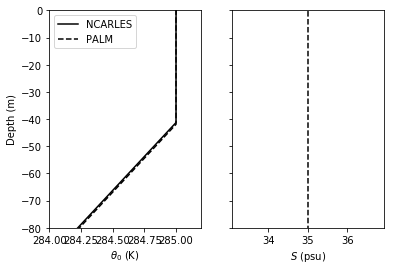

In [5]:
fig, axarr = plt.subplots(1, 2, sharey='row')
h0, = data0_pfl.read_profile('txym', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[0], xlabel=r'$\theta_0$ (K)', ylabel='Depth (m)',
                           xlim=[284, 285.2], ylim=[-80, 0],
                           color='k', linestyle='-')
h1, = data1_pfl.read_profile('pt', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[0], xlabel='off', ylabel='off',
                           color='k', linestyle='--')
data1_pfl.read_profile('sa', tidx_start=0, tidx_end=1).plot_mean(
                           axis=axarr[1], xlabel=r'$S$ (psu)', ylabel='off', color='k', linestyle='--')
axarr[0].legend([h0, h1], ['NCARLES', 'PALM'])

# save figure
if plot_figure:
    figname = fig_root+'/pfl_initial_TS.png'
    plt.savefig(figname, dpi = 300)

### Temperature and salinity profiles at the end of the simulation

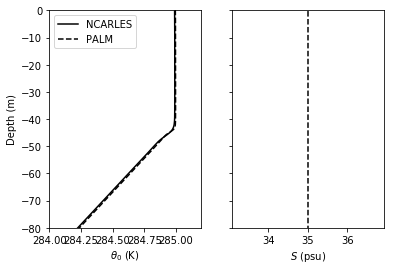

In [6]:
fig, axarr = plt.subplots(1, 2, sharey='row')
h0, = data0_pfl.read_profile('txym', tidx_start=-1).plot_mean(
                           axis=axarr[0], xlabel=r'$\theta_0$ (K)', ylabel='Depth (m)',
                           xlim=[284, 285.2], ylim=[-80, 0],
                           color='k', linestyle='-')
h1, = data1_pfl.read_profile('pt', tidx_start=-1).plot_mean(
                           axis=axarr[0], xlabel='off', ylabel='off',
                           color='k', linestyle='--')
data1_pfl.read_profile('sa', tidx_start=-1).plot_mean(
                           axis=axarr[1], xlabel=r'$S$ (psu)', ylabel='off', color='k', linestyle='--')
axarr[0].legend([h0, h1], ['NCARLES', 'PALM'])

# save figure
if plot_figure:
    figname = fig_root+'/pfl_final_TS.png'
    plt.savefig(figname, dpi = 300)

### Mean boundary layer depth defined by the maximum N^2

In [7]:
txym = data0_pfl.read_profile('txym', tidx_start=tidx0_start, tidx_end=tidx0_end)
NNT_data = (txym.data[:,1:]-txym.data[:,0:-1])/(txym.z[1:]-txym.z[0:-1])
NNT_z = 0.5*(txym.z[1:]+txym.z[0:-1])
NNT = LESProfile(data=NNT_data, data_name=r'$N^2_T$', z=NNT_z, time=time0[tidx0_start:tidx0_end])
zidx = np.argmax(NNT.data, axis=1)
hb0 = np.abs(NNT.z[zidx].mean())
print('h_b0 (NCARLES) = {:6.2f} m'.format(hb0))

prho = data1_pfl.read_profile('prho', tidx_start=tidx1_start, tidx_end=tidx1_end)
NN_data = -g*(prho.data[:,1:]-prho.data[:,0:-1])/(prho.z[1:]-prho.z[0:-1])/rho_0
NN_z = 0.5*(prho.z[1:]+prho.z[0:-1])
NN = LESProfile(data=NN_data, data_name=r'$N^2$', data_units=r's$^{-2}$', z=NN_z, time=time1[tidx1_start:tidx1_end])
zidx = np.argmax(NN.data, axis=1)
hb1 = np.abs(NN.z[zidx].mean())
print('h_b1 (PALM) = {:6.2f} m'.format(hb1))

h_b0 (NCARLES) =  45.03 m
h_b1 (PALM) =  44.54 m


### Temperature variance

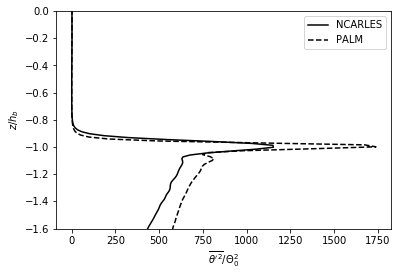

In [8]:
# normalizing factor
norm0 = 1/(Q0/ustar)**2
znorm0 = 1/hb0
norm1 = 1/(Q0/ustar)**2
znorm1 = 1/hb1
data0_pfl.read_profile('tps', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             norm=norm0, znorm=znorm0,
                             xlabel=r'$\overline{{\theta^\prime}^2}/\Theta_0^2$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax],
                             color='k', linestyle='-', label='NCARLES')
data1_pfl.read_profile('pt*2', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1,
                             xlabel='off', ylabel='off', ylim=[ymin, ymax],
                             color='k', linestyle='--', label='PALM')
plt.legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_temperature_variance.png'
    plt.savefig(figname, dpi = 300)

### Temperature fluxes

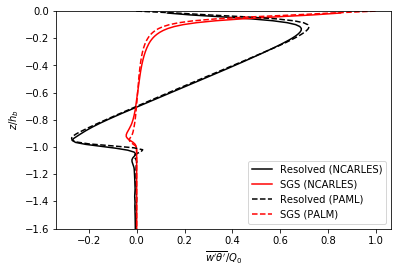

In [9]:
# normalizing factor
norm0 = 1/Q0
znorm0 = 1/hb0
norm1 = 1/Q0
znorm1 = 1/hb1
data0_pfl.read_profile('wtle', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             norm=norm0, znorm=znorm0,
                             xlabel=r'$\overline{w^\prime \theta^\prime}/Q_0$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax],
                             color='k', linestyle='-', label='Resolved (NCARLES)')
data0_pfl.read_profile('wtsb', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             norm=norm0, znorm=znorm0, xlabel='off', ylabel='off',
                             color='r', linestyle='-', label='SGS (NCARLES)')
data1_pfl.read_profile('w*pt*', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1,
                             xlabel='off', ylabel='off', ylim=[ymin, ymax],
                             color='k', linestyle='--', label='Resolved (PAML)')
data1_pfl.read_profile('w"pt"', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1, xlabel='off', ylabel='off',
                             color='r', linestyle='--', label='SGS (PALM)')
plt.legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_temperature_flux.png'
    plt.savefig(figname, dpi = 300)

### Mean velocity

Stokes drift not found. Skip.


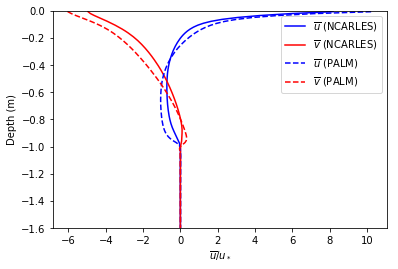

In [10]:
norm0 = 1/ustar
znorm0 = 1/hb0
norm1 = 1/ustar
znorm1 = 1/hb1
data0_pfl.read_profile('uxym', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             norm=norm0, znorm=znorm0,
                             xlabel=r'$\overline{u}/u_*$',
                             ylabel='Depth (m)', ylim=[ymin, ymax], label='$\overline{u}$ (NCARLES)',
                             color='b', linestyle='-')
data0_pfl.read_profile('vxym', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             norm=norm0, znorm=znorm0,
                             xlabel='off', ylabel='off', label='$\overline{v}$ (NCARLES)',
                             color='r', linestyle='-')
data1_pfl.read_profile('u', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1,
                             xlabel=r'$\overline{u}/u_*$',
                             ylabel='Depth (m)', ylim=[ymin, ymax], label='$\overline{u}$ (PALM)',
                             color='b', linestyle='--')
data1_pfl.read_profile('v', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1,
                             xlabel='off', ylabel='off', label='$\overline{v}$ (PALM)',
                             color='r', linestyle='--')
try:
    data1_pfl.read_profile('u_stk', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1, xlabel='off', ylabel='off',
                             color='g', linestyle='-', label='$u^S$ (PALM)')
    data1_pfl.read_profile('v_stk', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             norm=norm1, znorm=znorm1, xlabel='off', ylabel='off',
                             color='y', linestyle='--', label='$v^S$ (PALM)')
    data0_pfl.read_profile('stokes', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             norm=norm0, znorm=znorm0, xlabel='off', ylabel='off',
                             color='g', linestyle='-', label='$u^S$ (NCARLES)')
except ValueError:
    print('Stokes drift not found. Skip.')
    
plt.legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_mean_uv.png'
    plt.savefig(figname, dpi = 300)

### Momentum fluxes

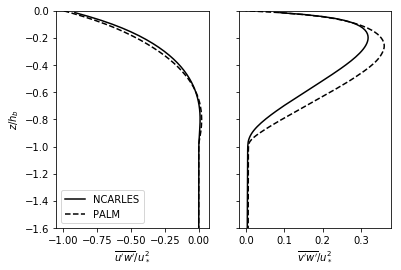

In [11]:
# normalizaing factor
norm0 = 1/ustar**2
znorm0 = 1/hb0
norm1 = 1/ustar**2
znorm1 = 1/hb1
# subplots
fig, axarr = plt.subplots(1, 2, sharey='row')
data0_pfl.read_profile('uw',tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                            axis=axarr[0], norm=norm0, znorm=znorm0,
                            xlabel=r'$\overline{u^\prime w^\prime}/u_*^2$',
                            ylabel=r'$z/h_b$', ylim=[ymin, ymax],
                            color='k', linestyle='-', label='NCARLES')
data0_pfl.read_profile('vw', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                            axis=axarr[1], norm=norm0, znorm=znorm0, 
                            xlabel=r'$\overline{v^\prime w^\prime}/u_*^2$', ylabel='off',
                            color='k', linestyle='-')

data1_pfl.read_profile('wu', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                            axis=axarr[0], norm=norm1, znorm=znorm1,
                            xlabel='off', ylabel='off', ylim=[ymin, ymax],
                            color='k', linestyle='--', label='PALM')
data1_pfl.read_profile('wv', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                            axis=axarr[1], norm=norm1, znorm=znorm1, 
                            xlabel='off', ylabel='off',
                            color='k', linestyle='--')
axarr[0].legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_momentum_flux.png'
    plt.savefig(figname, dpi = 300)

### Velocity variance

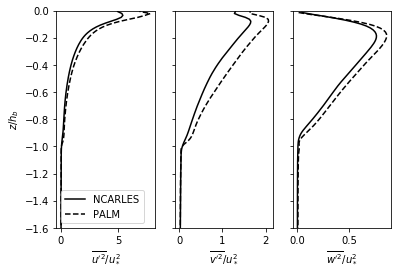

In [12]:
# normalizing factor
norm0 = 1/ustar**2
znorm0 = 1/hb0
norm1 = 1/ustar**2
znorm1 = 1/hb1
# subplots
fig, axarr = plt.subplots(1, 3, sharey='row')
# lower right panel
data0_pfl.read_profile('ups', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             axis=axarr[0], norm=norm0, znorm=znorm0,
                             xlabel=r'$\overline{{u^\prime}^2}/u_*^2$',
                             ylabel=r'$z/h_b$', ylim=[ymin, ymax],
                             color='k', linestyle='-', label='NCARLES')
data0_pfl.read_profile('vps', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             axis=axarr[1], norm=norm0, znorm=znorm0,
                             xlabel=r'$\overline{{v^\prime}^2}/u_*^2$', ylabel='off',
                             color='k', linestyle='-')
data0_pfl.read_profile('wps', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                             axis=axarr[2], norm=norm0, znorm=znorm0,
                             xlabel=r'$\overline{{w^\prime}^2}/u_*^2$', ylabel='off',
                             color='k', linestyle='-')

data1_pfl.read_profile('u*2', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             axis=axarr[0], norm=norm1, znorm=znorm1,
                             xlabel='off', ylabel='off', ylim=[ymin, ymax],
                             color='k', linestyle='--', label='PALM')
data1_pfl.read_profile('v*2', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             axis=axarr[1], norm=norm1, znorm=znorm1,
                             xlabel='off', ylabel='off', color='k', linestyle='--')
data1_pfl.read_profile('w*2', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                             axis=axarr[2], norm=norm1, znorm=znorm1,
                             xlabel='off', ylabel='off', color='k', linestyle='--')
axarr[0].legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_velocity_variance.png'
    plt.savefig(figname, dpi = 300)

### TKE

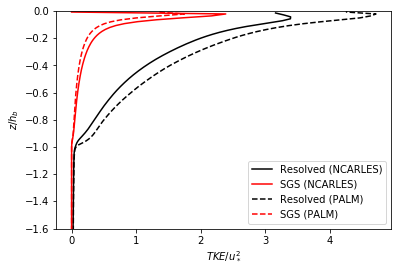

In [13]:
# normalizing factor
norm0 = 1/ustar**2
znorm0 = 1/hb0
norm1 = 1/ustar**2
znorm1 = 1/hb1

e0_res = data0_pfl.read_profile('englez', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                norm=norm0, znorm=znorm0, xlabel=r'$TKE/u_*^2$', ylabel=r'$z/h_b$', ylim=[ymin, ymax],
                color='k', linestyle='-', label='Resolved (NCARLES)')
e0_sgs = data0_pfl.read_profile('engsbz', tidx_start=tidx0_start, tidx_end=tidx0_end).plot_mean(
                norm=norm0, znorm=znorm0, xlabel='off', ylabel='off',
                color='r', linestyle='-', label='SGS (NCARLES)')

e1_res = data1_pfl.read_profile('e*', tidx_start=tidx1_start, tidx_end=tidx1_end).plot_mean(
                norm=norm1, znorm=znorm1, xlabel='off', ylabel='off', ylim=[ymin, ymax],
                color='k', linestyle='--', label='Resolved (PALM)')
e1_sgs = data1_pfl.read_profile('e', tidx_start=tidx1_start, tidx_end=tidx1_end)
e1_sgs.z[0] = np.nan # fix the invalid depth of e at the bottom
e1_sgs.plot_mean(norm=norm1, znorm=znorm1, xlabel='off', ylabel='off',
                color='r', linestyle='--', label='SGS (PALM)')
plt.legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_TKE.png'
    plt.savefig(figname, dpi = 300)

### Vertial velocity skewness

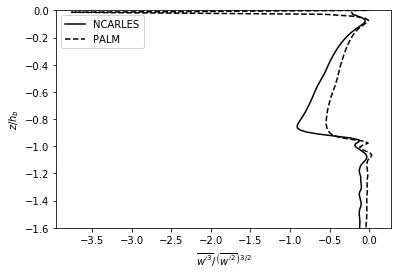

In [14]:
# normalizing factor
norm0 = 1
znorm0 = 1/hb0
norm1 = 1
znorm1 = 1/hb1

wcube0 = data0_pfl.read_profile('wcube', tidx_start=tidx0_start, tidx_end=tidx0_end)
wps0 = data0_pfl.read_profile('wps', tidx_start=tidx0_start, tidx_end=tidx0_end)
Sw0 = LESProfile(data=wcube0.data/wps0.data**(1.5), z=wcube0.z)
Sw0.plot_mean(norm=norm0, znorm=znorm0, 
              xlabel=r'$\overline{{w^\prime}^3} / \left(\overline{{w^\prime}^2}\right)^{3/2}$',
              ylabel=r'$z/h_b$', ylim=[ymin, ymax], color='k', linestyle='-', label='NCARLES')
Sw1 = data1_pfl.read_profile('Sw', tidx_start=tidx1_start, tidx_end=tidx1_end)
Sw1.plot_mean(norm=norm1, znorm=znorm1, xlabel='off', ylabel='off', ylim=[ymin, ymax],
              color='k', linestyle='--', label='PALM')
plt.legend()

# save figure
if plot_figure:
    figname = fig_root+'/pfl_w_skewness.png'
    plt.savefig(figname, dpi = 300)

###### 